In [1]:
import sys
sys.path.insert(0, '../python_scripts')
import json
import glob
import random
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import utils
import importlib
import threading
import meta
import heatmap
#metadata = utils.load("./variables/metadata.p")
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import *
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras import callbacks
from keras.preprocessing.image import Iterator
import os
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
import heatmap
remote = callbacks.RemoteMonitor(root='http://localhost:9000')
from shutil import copyfile
from keras.models import load_model
from keras.models import model_from_json
from keras.layers.advanced_activations import LeakyReLU
import time
import h_gen,meta
from meta import *
from h_gen import *
from utils import *
import gc 

Using Theano backend.
Using gpu device 0: GeForce GTX 960M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN None)


In [2]:
image_size = [(768, 1216),(1344,2240)]
FOLDER_TRAIN = "./temp_training/resnet/"

In [3]:
SPLIT = 0.8 # For the train/test split
metadata = meta.create_metadata()

['../JSONS/alb_labels.json', '../JSONS/bet_labels.json', '../JSONS/dol_labels.json', '../JSONS/lag_labels.json', '../JSONS/other_labels.json', '../JSONS/shark_labels.json', '../JSONS/yft_labels.json']



In [4]:
for img_size in image_size:
    dim = str(img_size[0])+'_'+str(img_size[1])+'/'
    mk(FOLDER_TRAIN+''+dim)

##### Let's do some precomputing:

In [ ]:
for img_size in image_size[1:]:
    print(img_size)
    dim = str(img_size[0])+'_'+str(img_size[1])+'/'
    model1 = ResNet50(include_top=False, input_shape=(3,) + img_size)
    model2 = Model(model1.input, model1.layers[-2].output)

    img_a = Input(shape=(3,) + img_size)
    x = model2(img_a)
    x = AveragePooling2D(pool_size=(7, 7), strides=(1,1), border_mode="valid")(x)
    model = Model(img_a, x)
    X = np.zeros((1, 3)+img_size)
    f = os.listdir(FOLDER_TRAIN + dim)
    del model1,model2
    gc.collect()
    output_size = heatmap.get_dim(model, -1, input_shape=(3,)+img_size)
    utils.save(output_size, FOLDER_TRAIN + dim +"mask_size")
    for key, v in tq(metadata.items()):
        if v["filename"]+ ".npy" not in f:
        # First of all, if there is no rectangle and the image is not in NoF, 
        # then there is a problem.

            if v["class"] != "NoF" and "rectangles" not in v:
                continue

            X[0] = img_to_array(load_img(v["path"],target_size=img_size))
            X = preprocess_input(X)
            y = model.predict(X)[0]
            utils.save_array(y, FOLDER_TRAIN +dim+ v["filename"])
    #output_size = heatmap.get_dim(model, -1, input_shape=(3,)+img_size)
    #utils.save(output_size, FOLDER_TRAIN + dim +"mask_size")

    

## First step, create train and test set.

In [5]:
import operator
output_size = []
nb_filters = []
mask_size = []
def find_bigger(mask):
    obj = []
    for i,m in enumerate(mask):
        obj.append([i,m[0]*m[1]])
    return sorted(obj,key=operator.itemgetter(1),reverse=True)[0][0]
    
for i,img_size in enumerate(image_size):
    dim = str(img_size[0])+'_'+str(img_size[1])+'/'
    output_size.append(utils.load(FOLDER_TRAIN +dim+ "mask_size"))
    nb_filters.append(output_size[0][0])
    mask_size.append(output_size[i][1:])
    print("size of our filters: " + str(nb_filters[i]))
    print("size of our mask: " + str(mask_size[i]))
nb_filters = nb_filters[0]
print(mask_size)
print(nb_filters)

size of our filters: 2048
size of our mask: (18, 32)
size of our filters: 2048
size of our mask: (36, 64)
[(18, 32), (36, 64)]
2048


In [6]:
##THAT PART IS ONLY FOR ME . AS I HAVE ONLY 127 IMAGES IN (1152, 2048)
def filter_sample_to_same(list_files):
    import collections
    collection = collections.defaultdict(list)
    for list_file in list_files:
        for f in list_file:
            collection[f.split('/')[-1].split('.')[0]].append(f)
    return collection
def filter_collection(collection):
    obj = []
    for key in collection.keys():
        if len(collection[key]) >1:
            obj.append(collection[key])
    return obj
        
def get_same_sample():
    list_files = []
    for img_size in image_size:    
        dim = str(img_size[0])+'_'+str(img_size[1])+'/'
        list_files.append(h_gen.get_all_images(regex=FOLDER_TRAIN +dim+ "*.npy"))
    return list_files
collection = filter_collection(filter_sample_to_same(get_same_sample()))
print(len(collection))

3777


In [7]:
list_files = []
list_files = [x[0].split('/')[-1].split('.')[0]+'.jpg'  for x in collection]
random.shuffle(list_files)
l = int(0.8 * len(list_files))

training_set = list_files[:l]
test_set = list_files[l:]
print("First element for debug: " + training_set[0])

First element for debug: img_00679.jpg


## Second step, create the data generator.

In [8]:
import importlib
importlib.reload(h_gen)

<module 'h_gen' from '../python_scripts\\h_gen.py'>

In [9]:
class DiskArrayIterator(Iterator):
    
    def __init__(self, batch_size, nb_filters, mask_size, folder, file_list, 
                 metadata,image_size, with_name = False, shuffle=False, seed=None,debug2=False):
        self.batch_size=batch_size
        self.nb_filters=nb_filters
        self.mask_size=mask_size
        self.folder=folder
        self.file_list=file_list
        self.metadata = metadata
        self.with_name = with_name
        self.image_size = image_size
        self.debug2 = debug2        
        super(DiskArrayIterator, self).__init__(len(file_list), batch_size, shuffle, seed)
    
    def find_bigger(mask):
        obj = []
        for i,m in enumerate(mask):
            obj.append([i,m[0]*m[1]])
        return sorted(obj,key=operator.itemgetter(1),reverse=True)[0][0]

    def next(self):
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        
        mask_larger = self.mask_size[find_bigger(self.mask_size)]
        reshaped = mask_larger[0]*mask_larger[1]
        X = [np.zeros((self.batch_size, self.nb_filters) + m) for m in self.mask_size]
        Y = [np.zeros((self.batch_size, reshaped,1)) for _ in range(5)]
        W = [np.zeros((self.batch_size, reshaped))   for _ in range(5)]
        selected_files = [self.file_list[i] for i in index_array]
        meta = [metadata[x] for x in selected_files]
        # We loop over the files
        is_rects = []
        for c, v in enumerate(meta):
            if not self.debug2:
                masks, m_weights = h_gen.get_5_masks_w(v, mask_larger)
            if self.debug2:
                masks, m_weights,is_rect = h_gen.get_5_masks_w(v, mask_larger,debug_bool=self.debug2)
                is_rects.append(is_rect)
            
            # loop over the 5 masks
            for i, mask in enumerate(masks):
                
                mask0 = np.expand_dims(mask, axis=0)
                mask0 = np.reshape(mask0,(reshaped,))
                y = np.expand_dims(mask0, axis=1)
                for j,image_size in enumerate(self.image_size):
                    dim = str(image_size[0])+'_'+str(image_size[1])+'/'
                    X[j][c] = utils.load_array(self.folder +dim+v["filename"])
                m_weight = np.expand_dims(m_weights[i], axis=0)
                m_weight = np.reshape(m_weight,(reshaped,))
                Y[i][c] = y
                W[i][c] = m_weight
        
        if self.debug2:
            return X, Y, W, [v["path"] for v in meta],is_rects
        if self.with_name:
            return X, Y, W, [v["path"] for v in meta]
        return X, Y, W
        #return X, Y

In [10]:
import importlib
importlib.reload(h_gen)

<module 'h_gen' from '../python_scripts\\h_gen.py'>

In [11]:
for X, Y, W , paths,is_rects in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size, with_name=True, seed=int(np.random.uniform(1,100)),shuffle=True,debug2=True):
    break

In [12]:
print("shape of X:", [x.shape for x in X])
print("lenght of Y:", len(Y))
print("shape of Y[0]:", Y[0].shape)
print("lenght of W:", len(W))
print("shape of W[0]:", W[0].shape)
print(is_rects)

shape of X: [(16, 2048, 18, 32), (16, 2048, 36, 64)]
lenght of Y: 5
shape of Y[0]: (16, 2304, 1)
lenght of W: 5
shape of W[0]: (16, 2304)
[True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True]


./trainT/ALB/img_05043.jpg


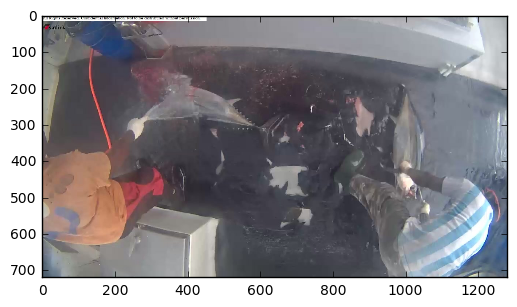

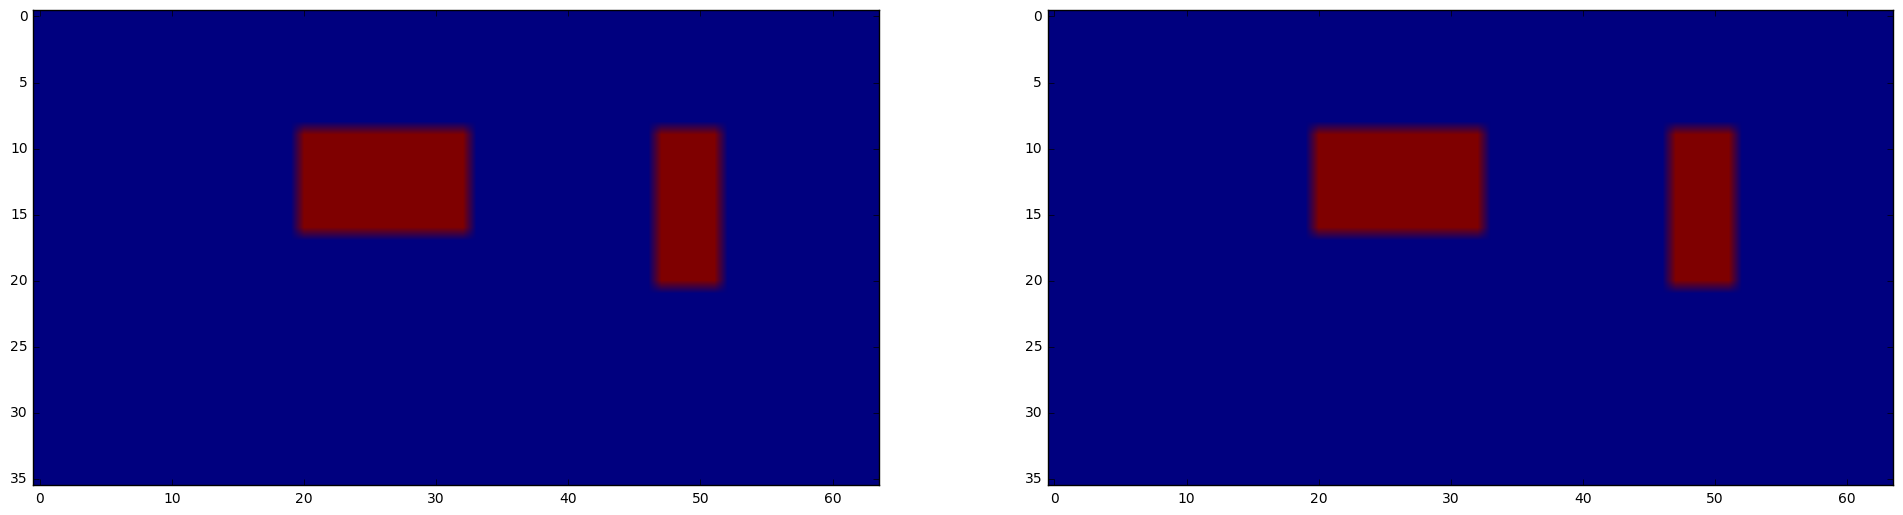

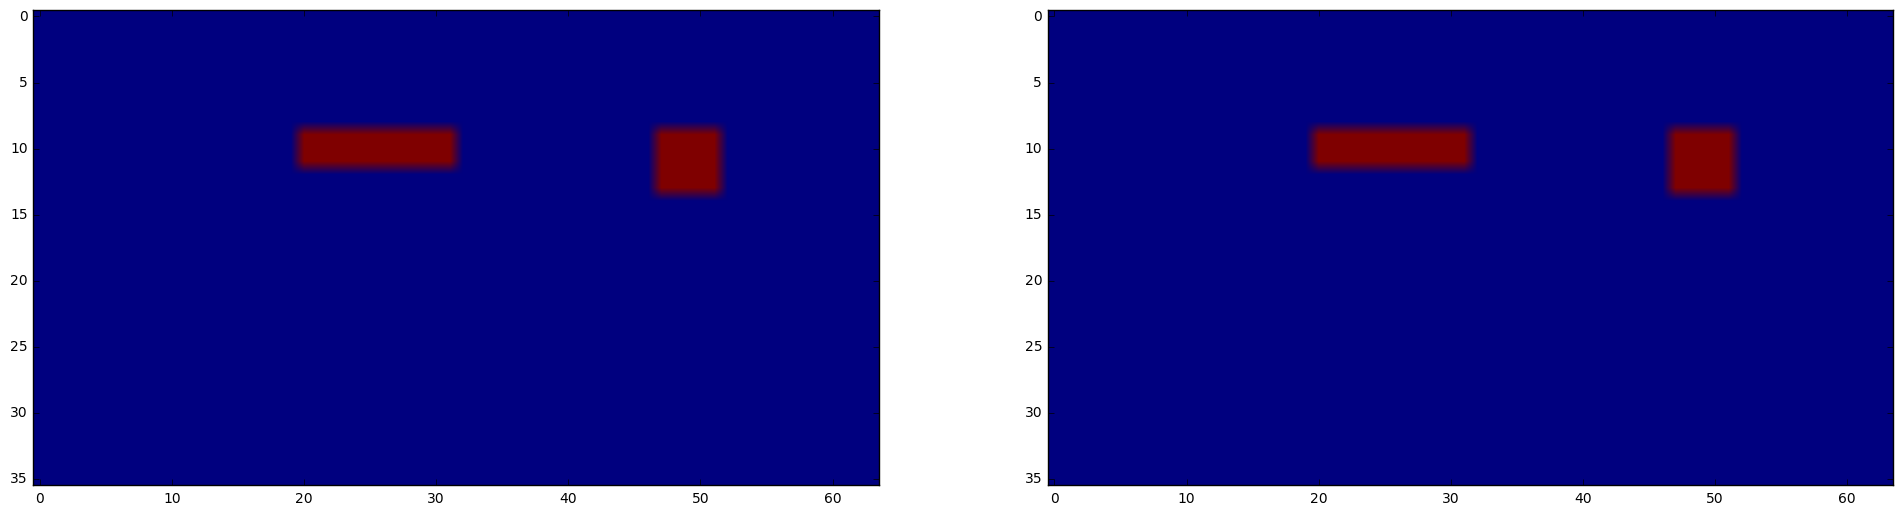

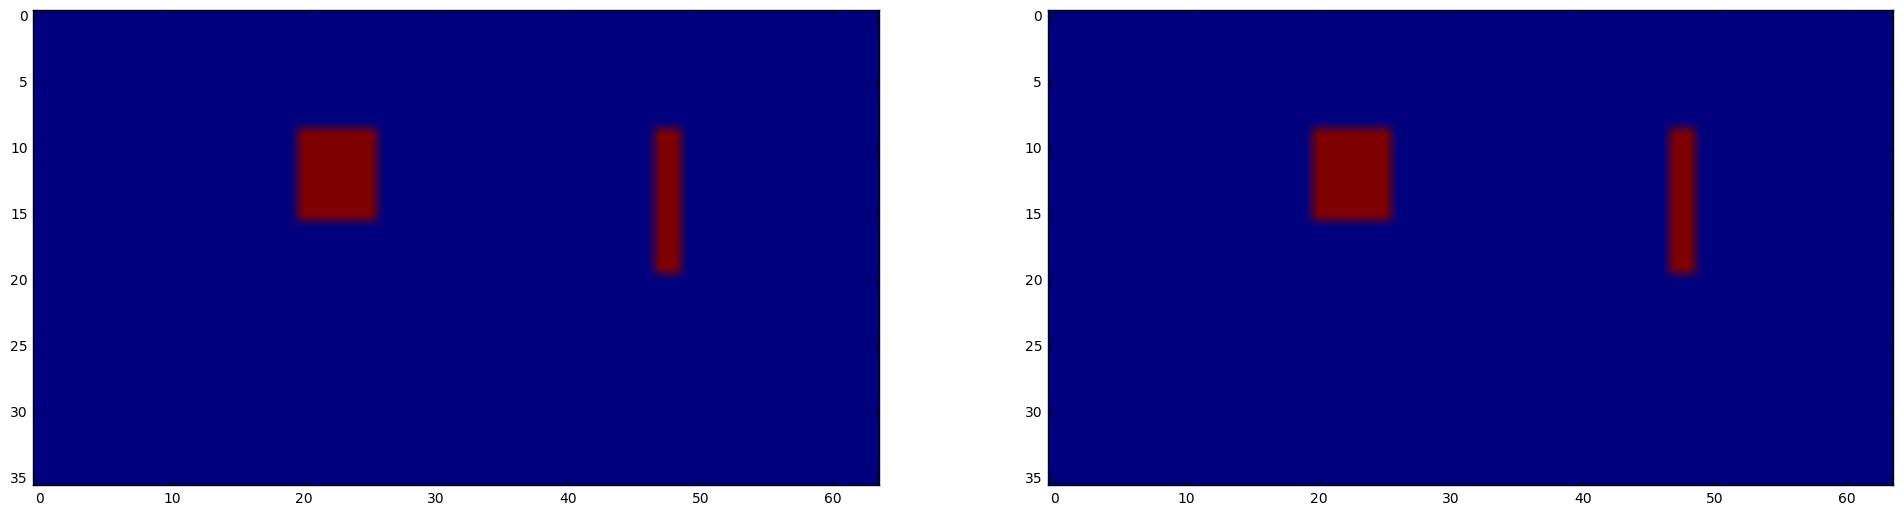

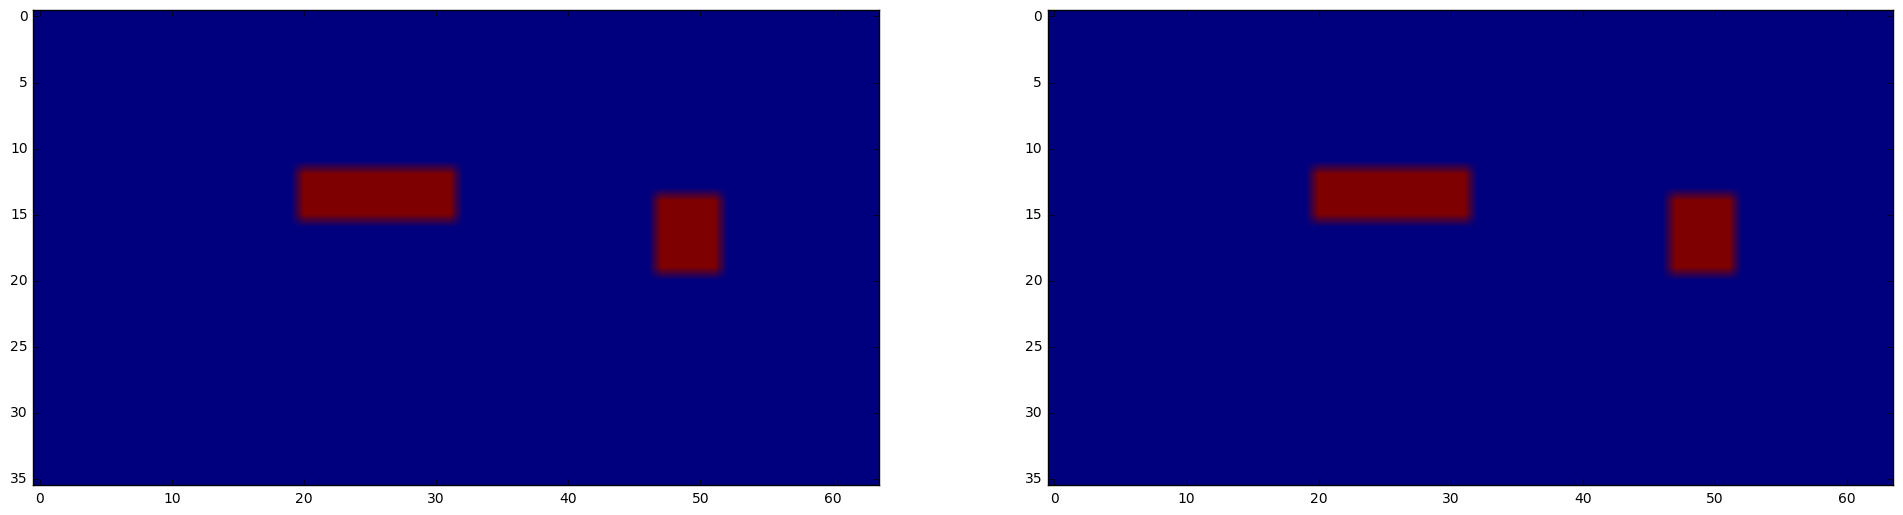

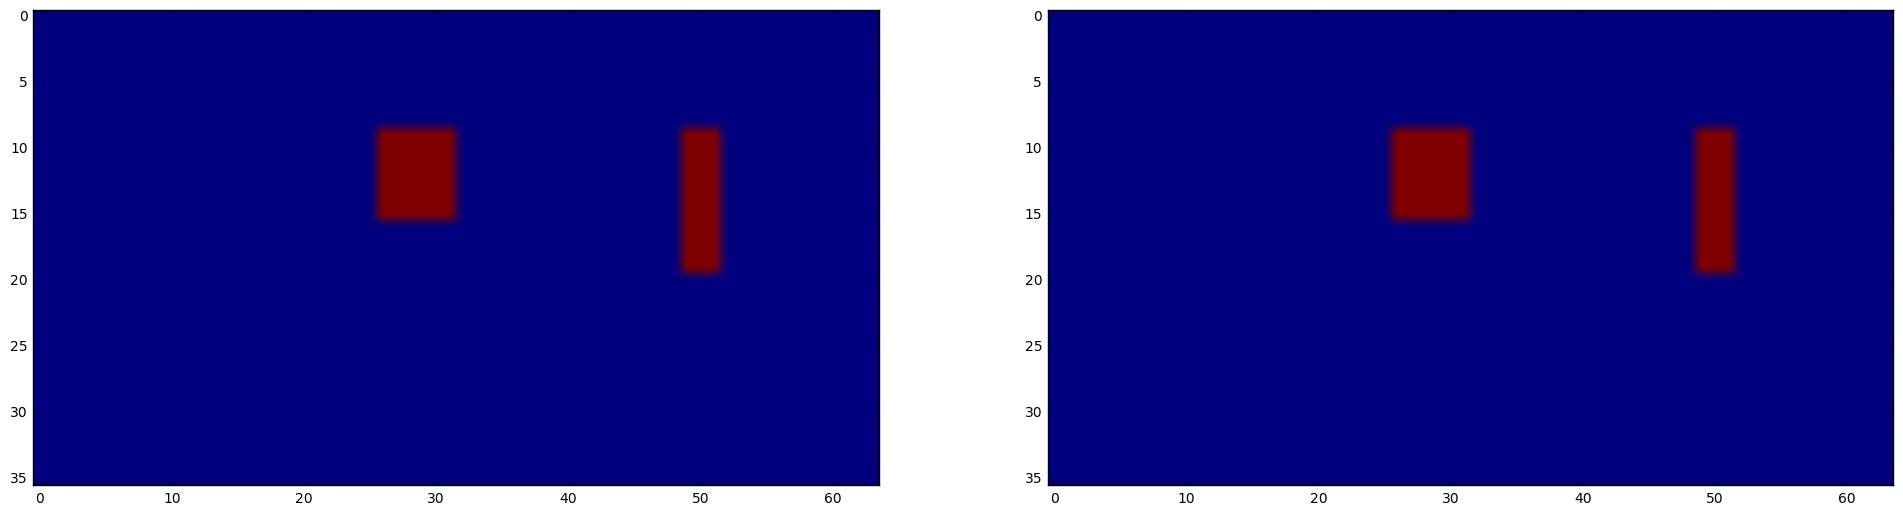

./trainT/OTHER/img_00721.jpg


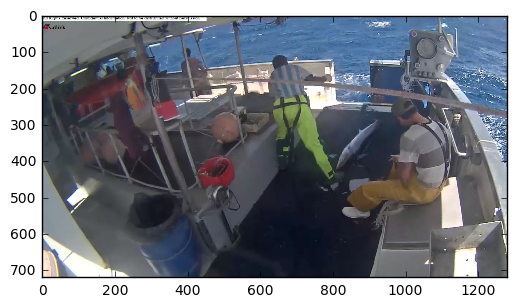

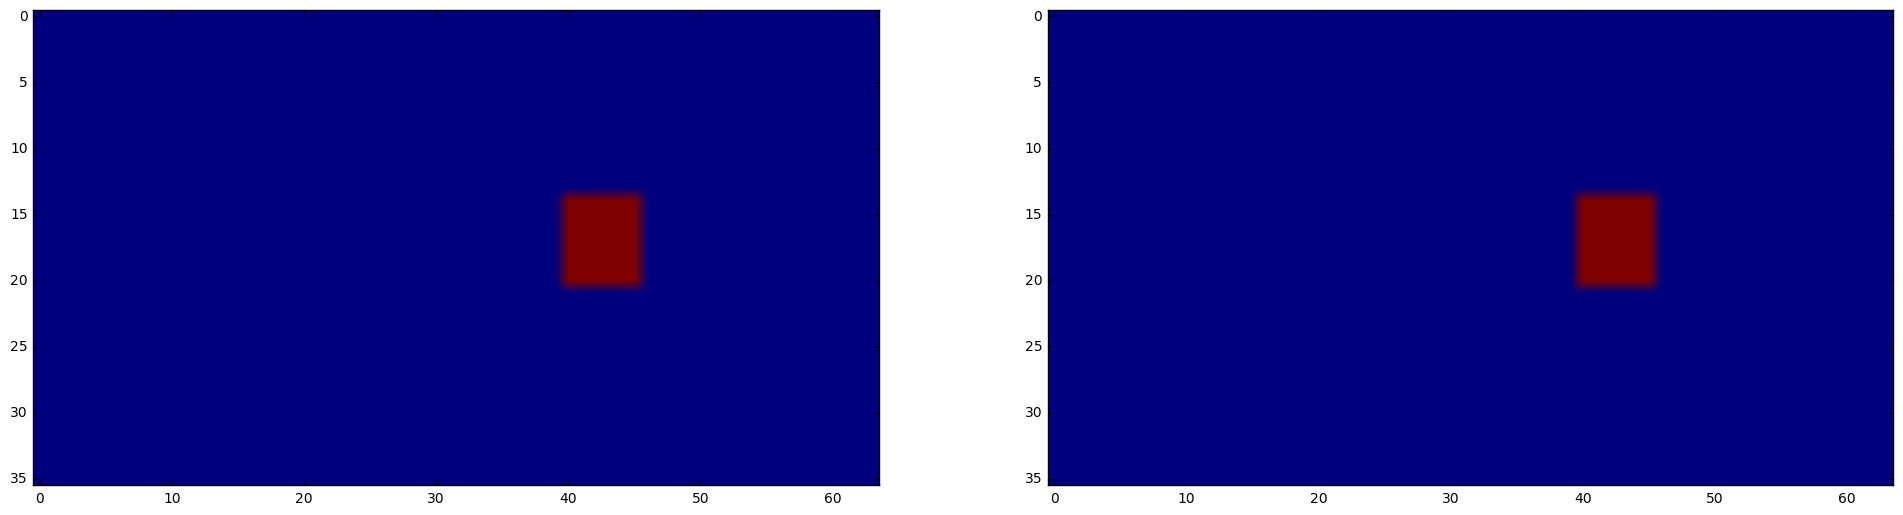

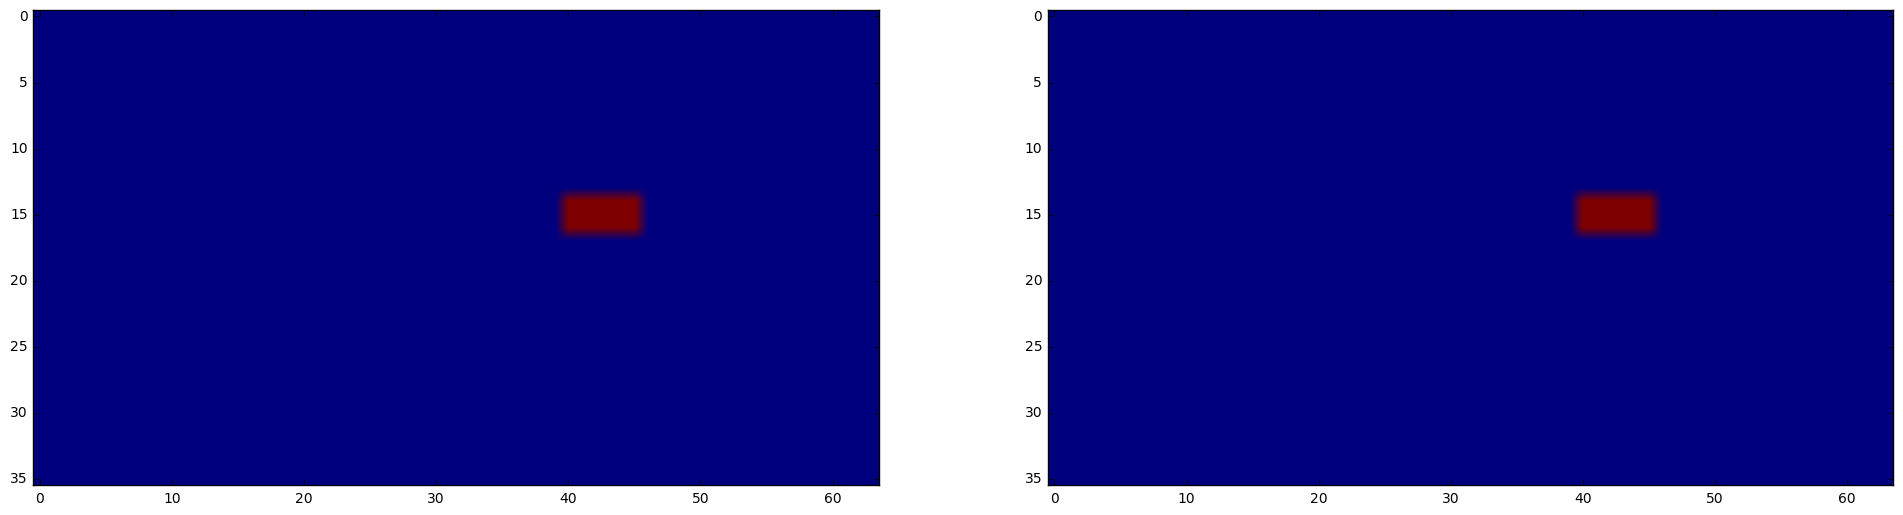

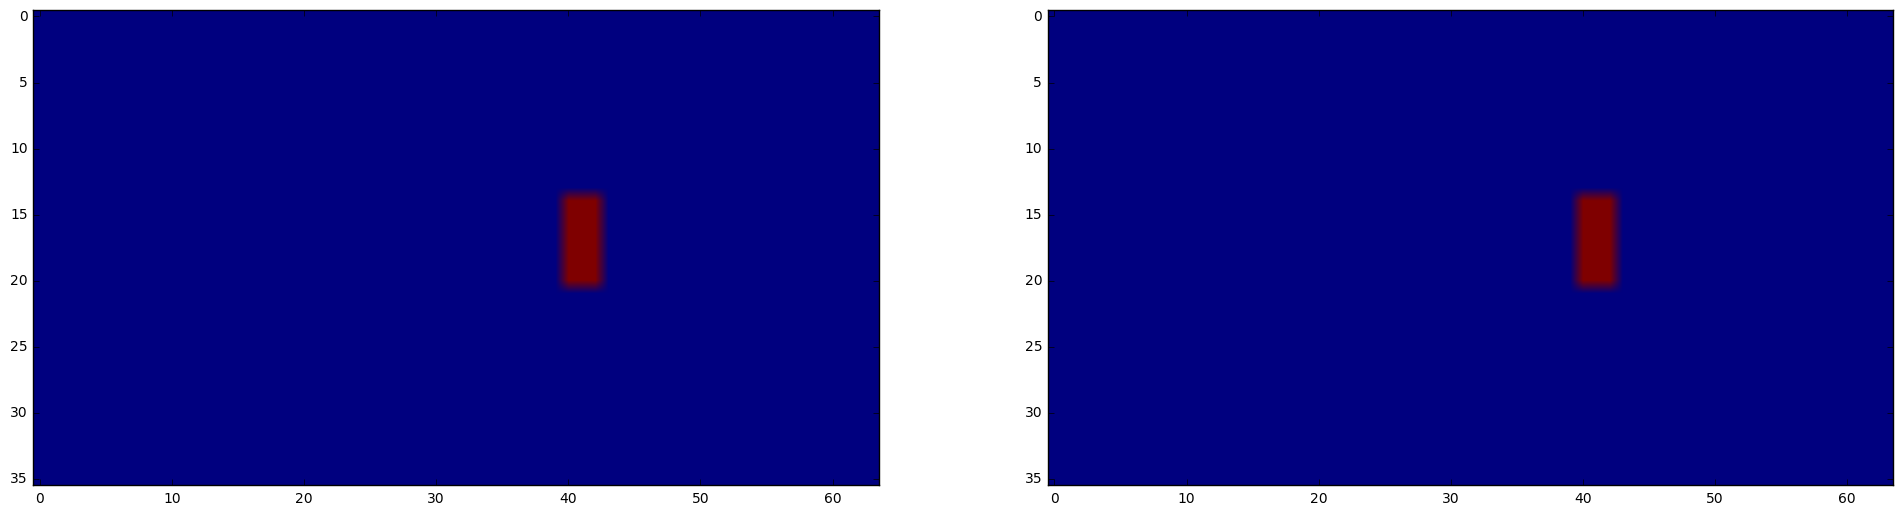

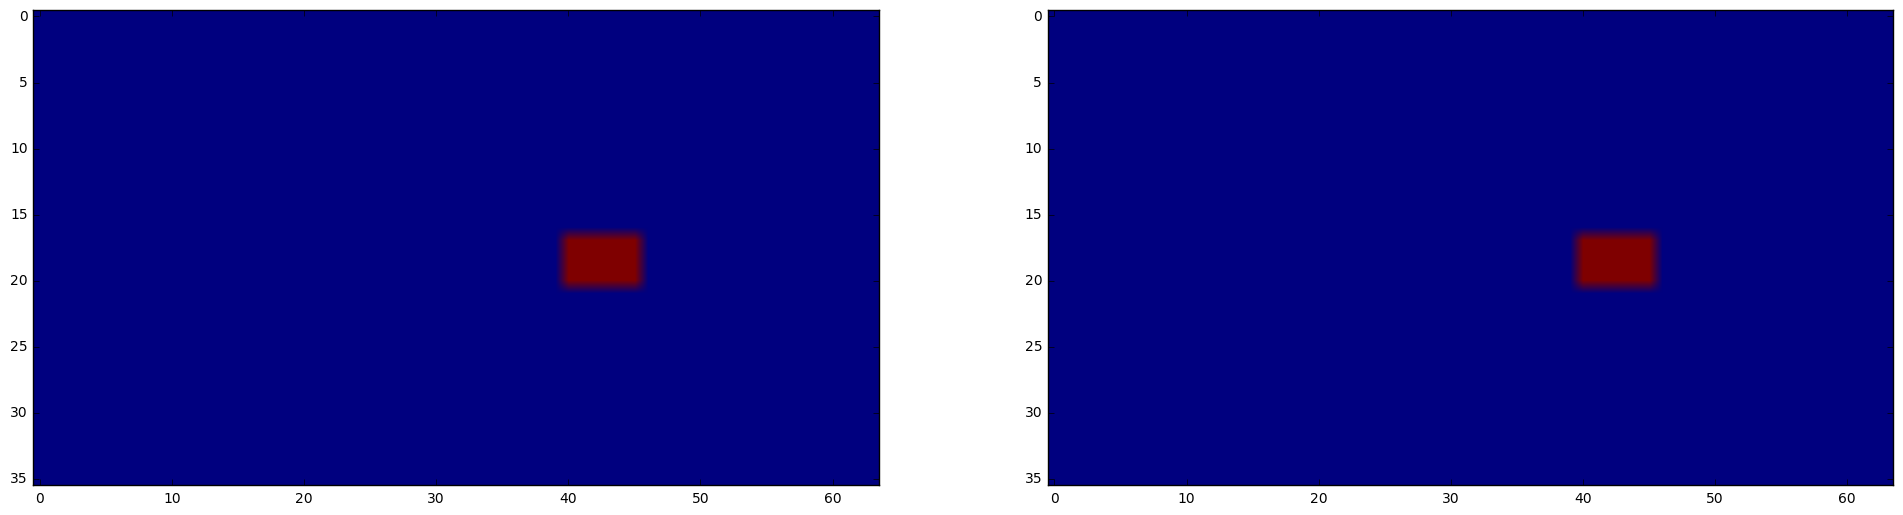

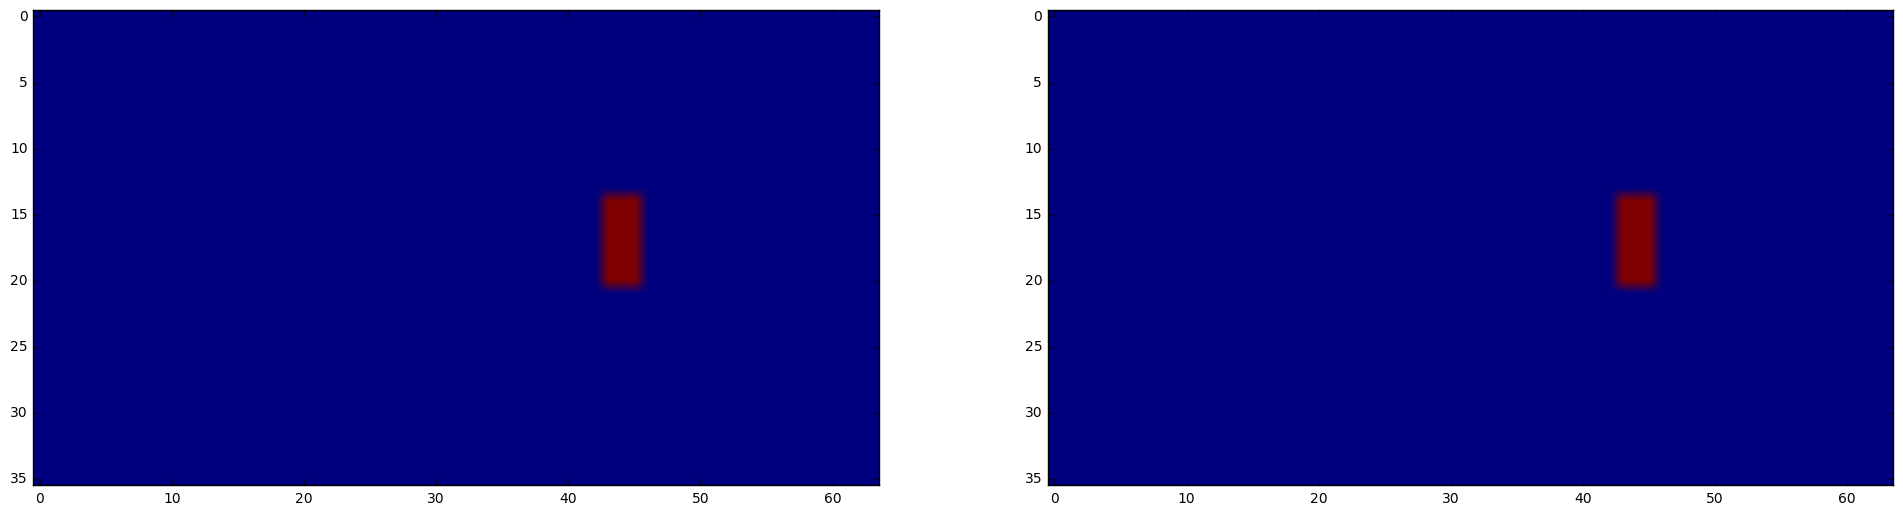

./trainT/ALB/img_07021.jpg


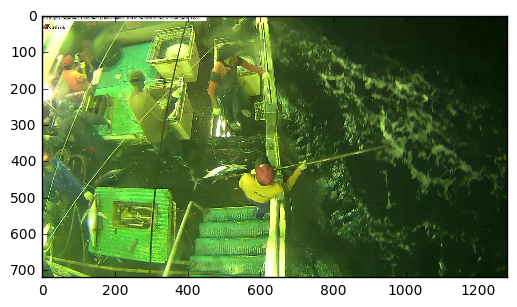

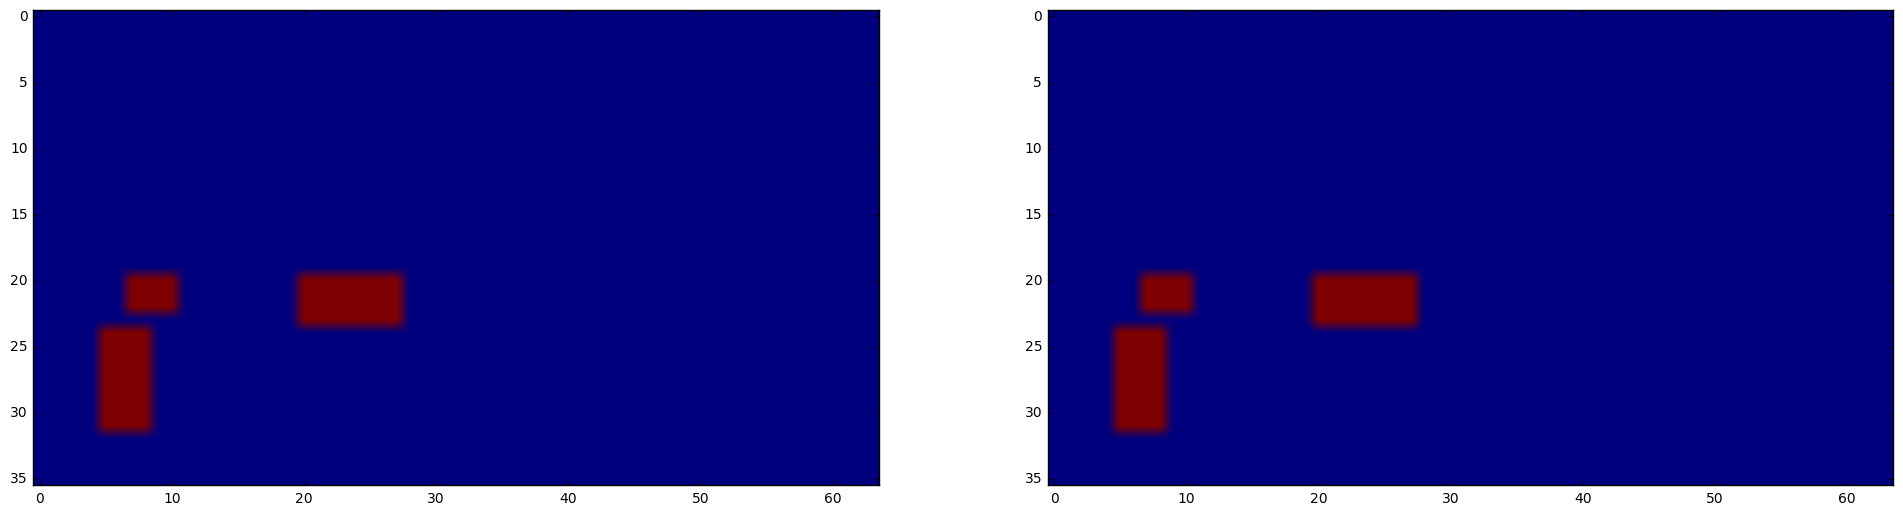

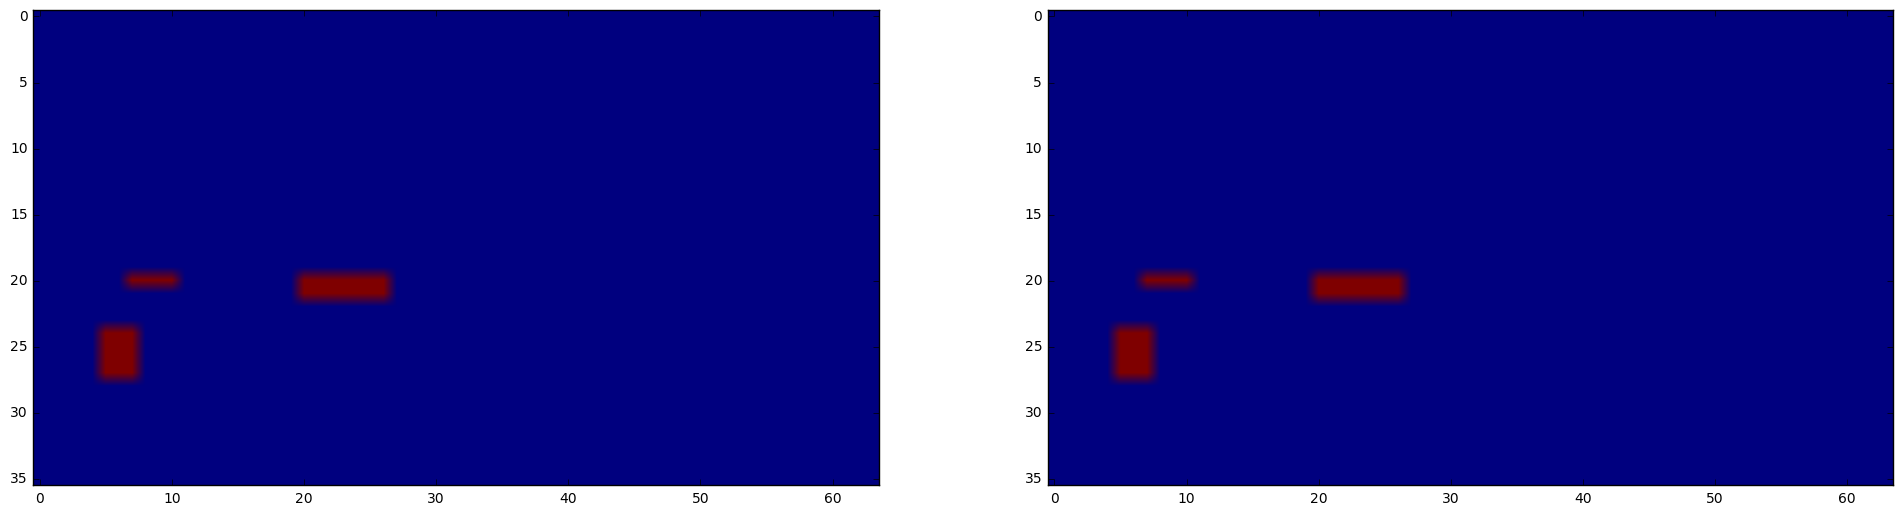

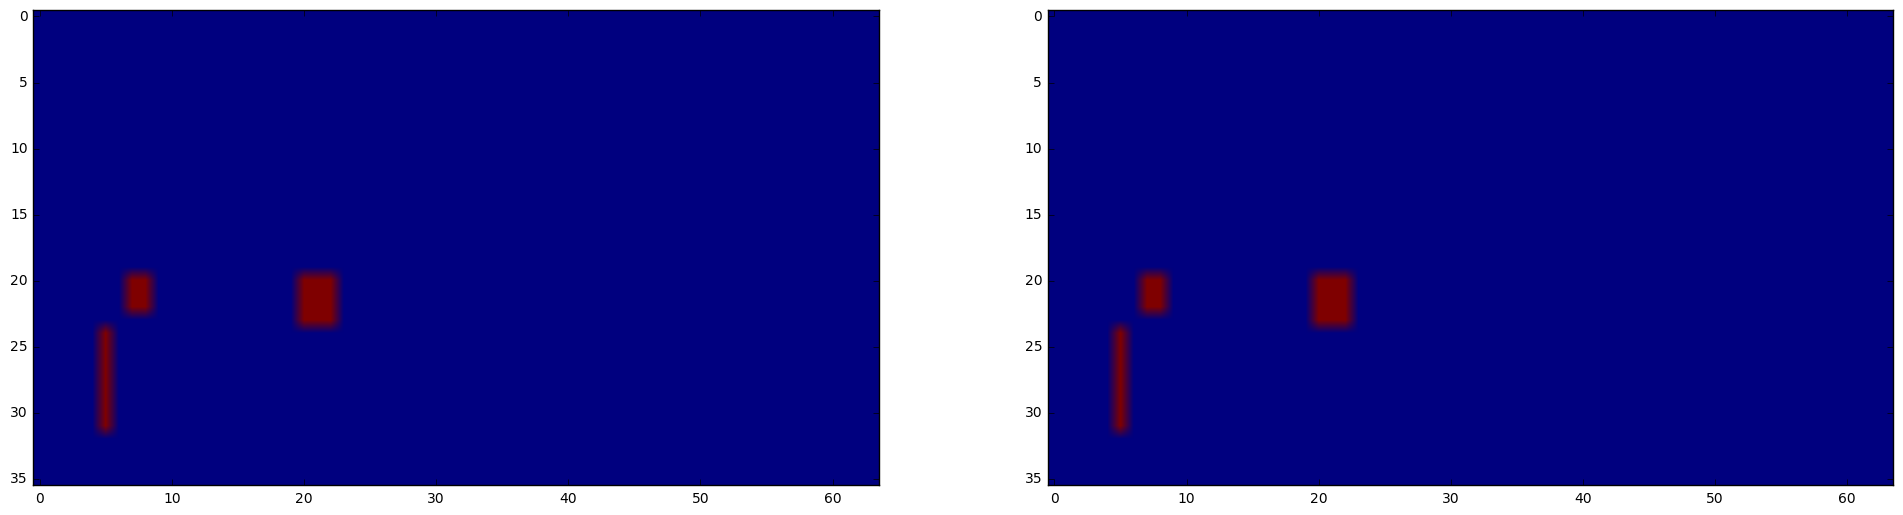

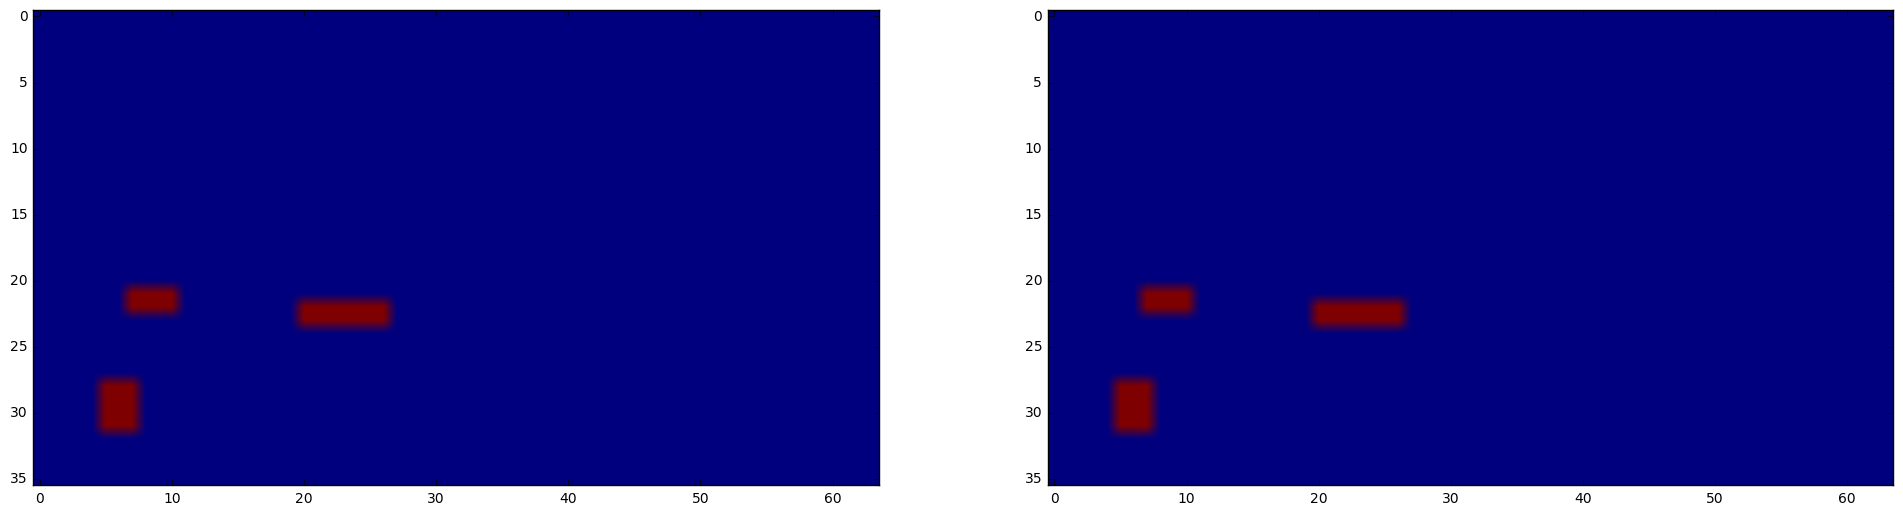

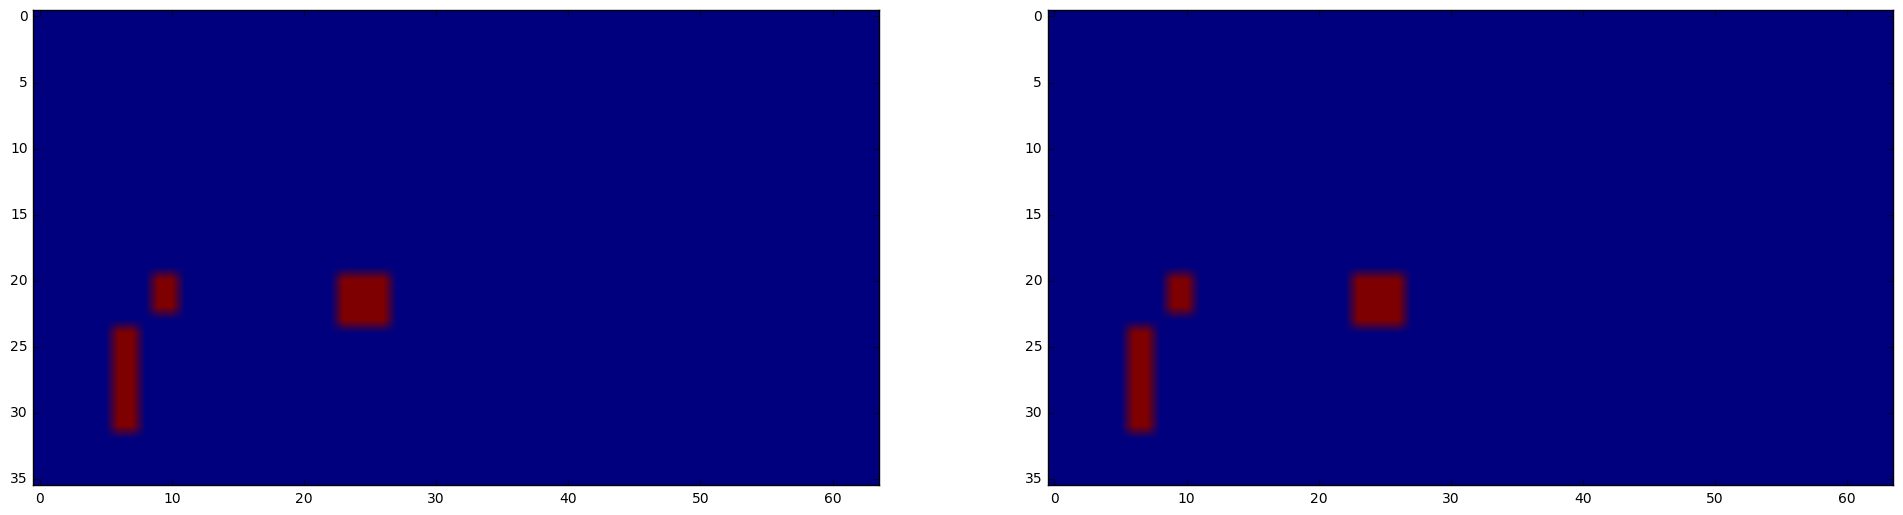

./trainT/OTHER/img_03243.jpg


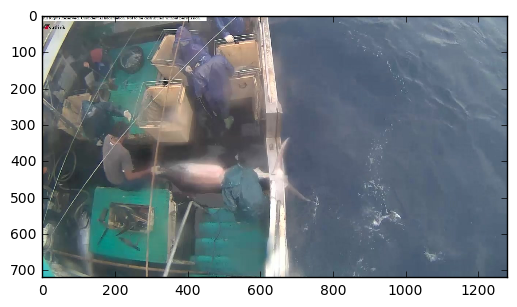

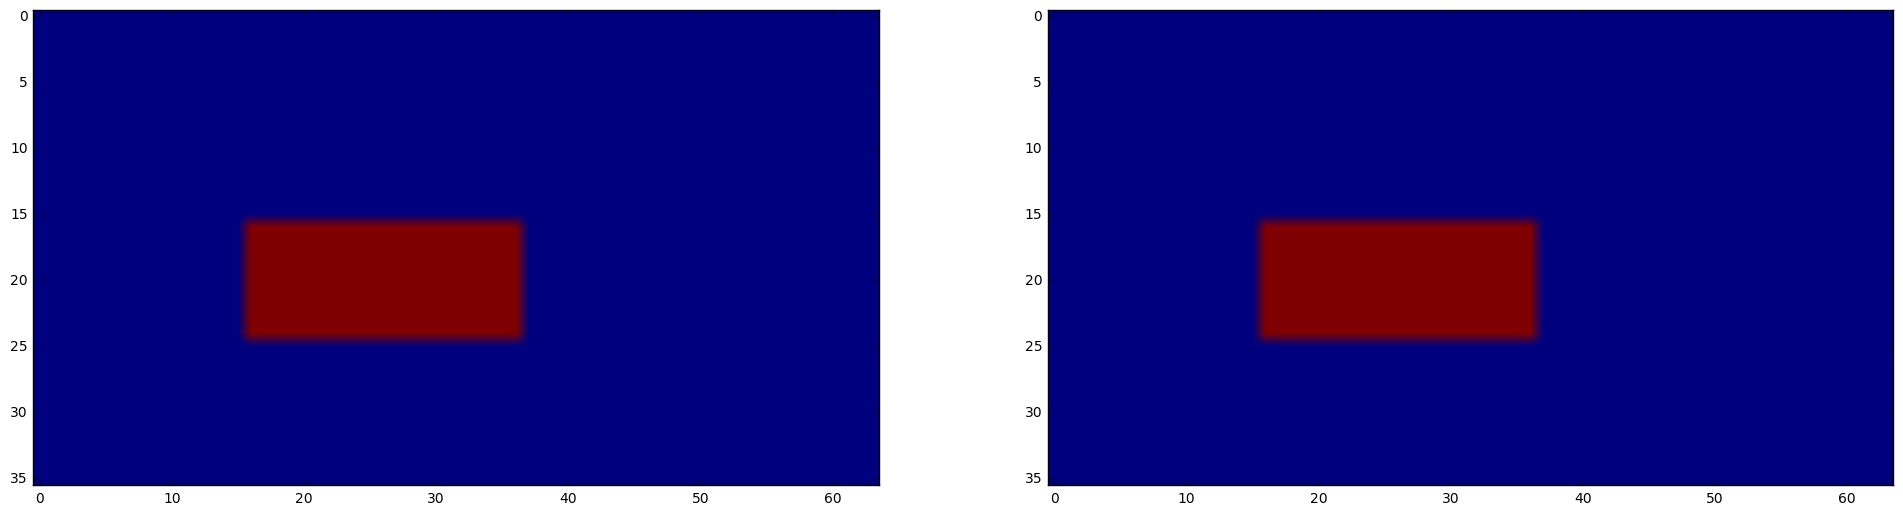

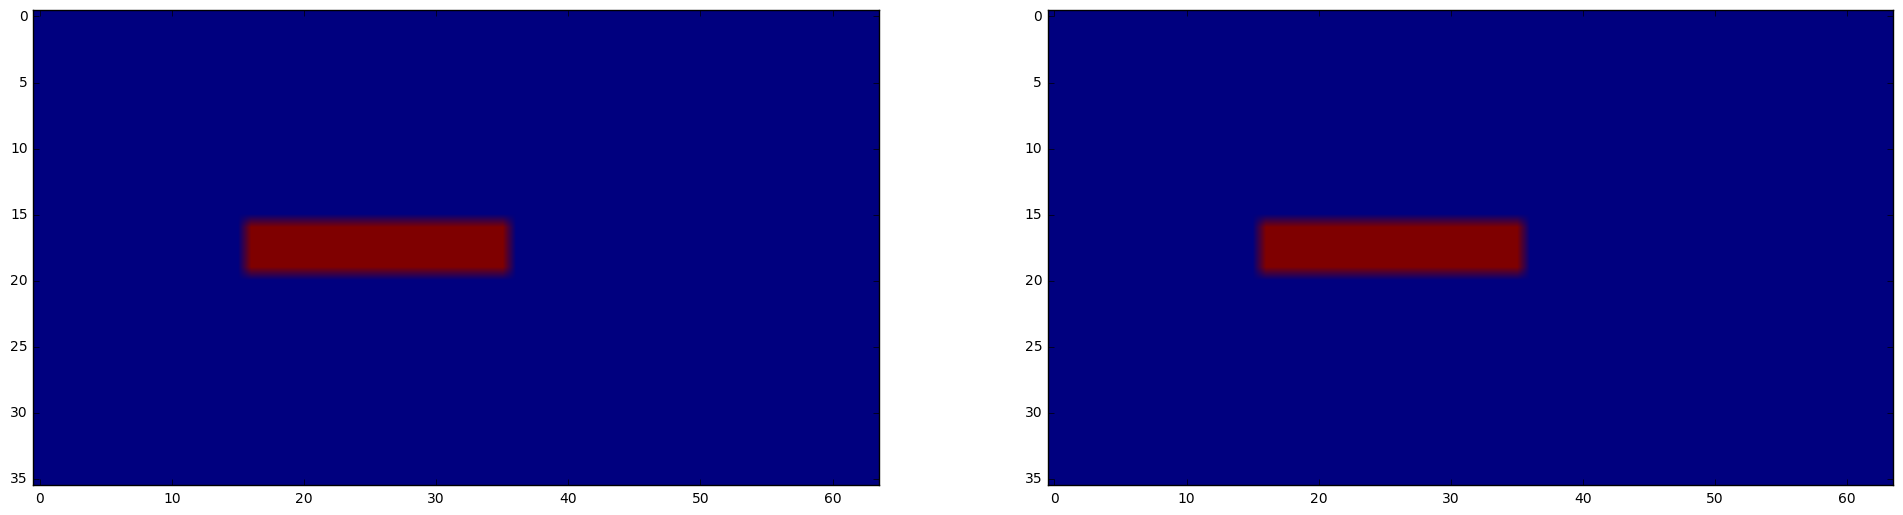

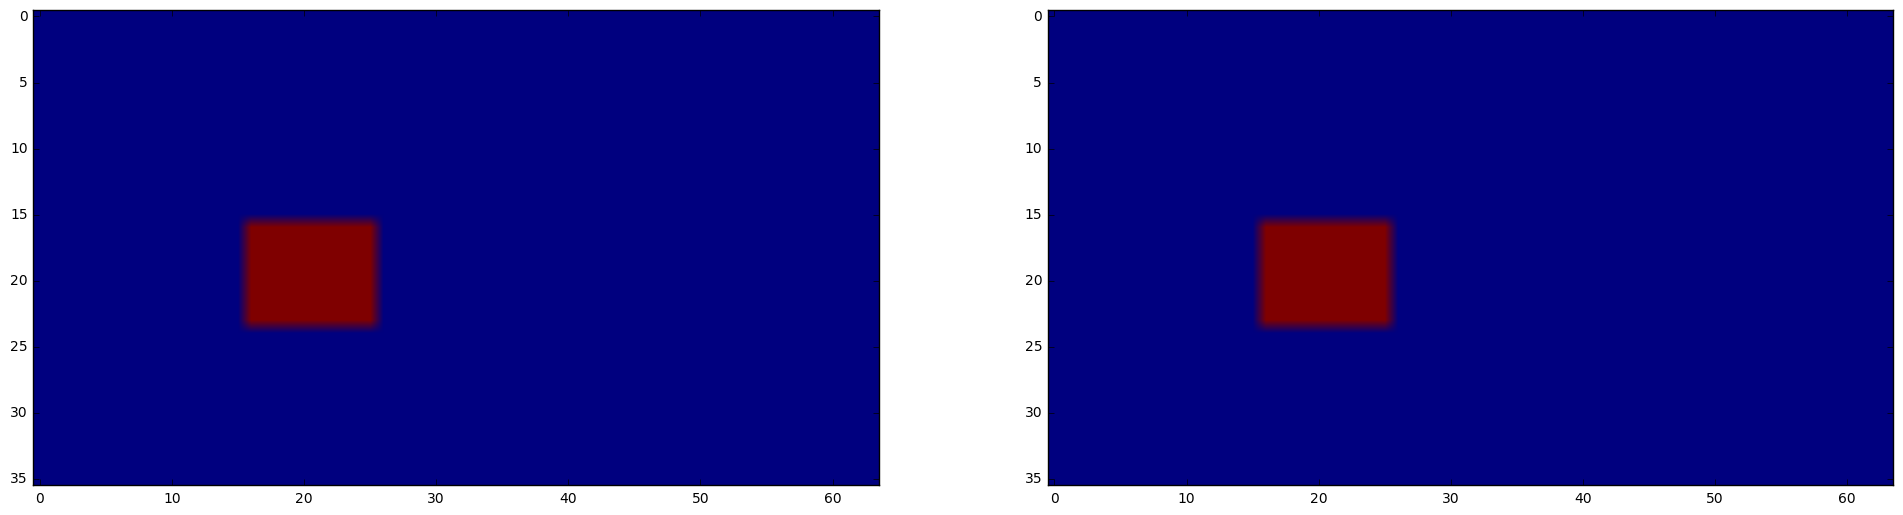

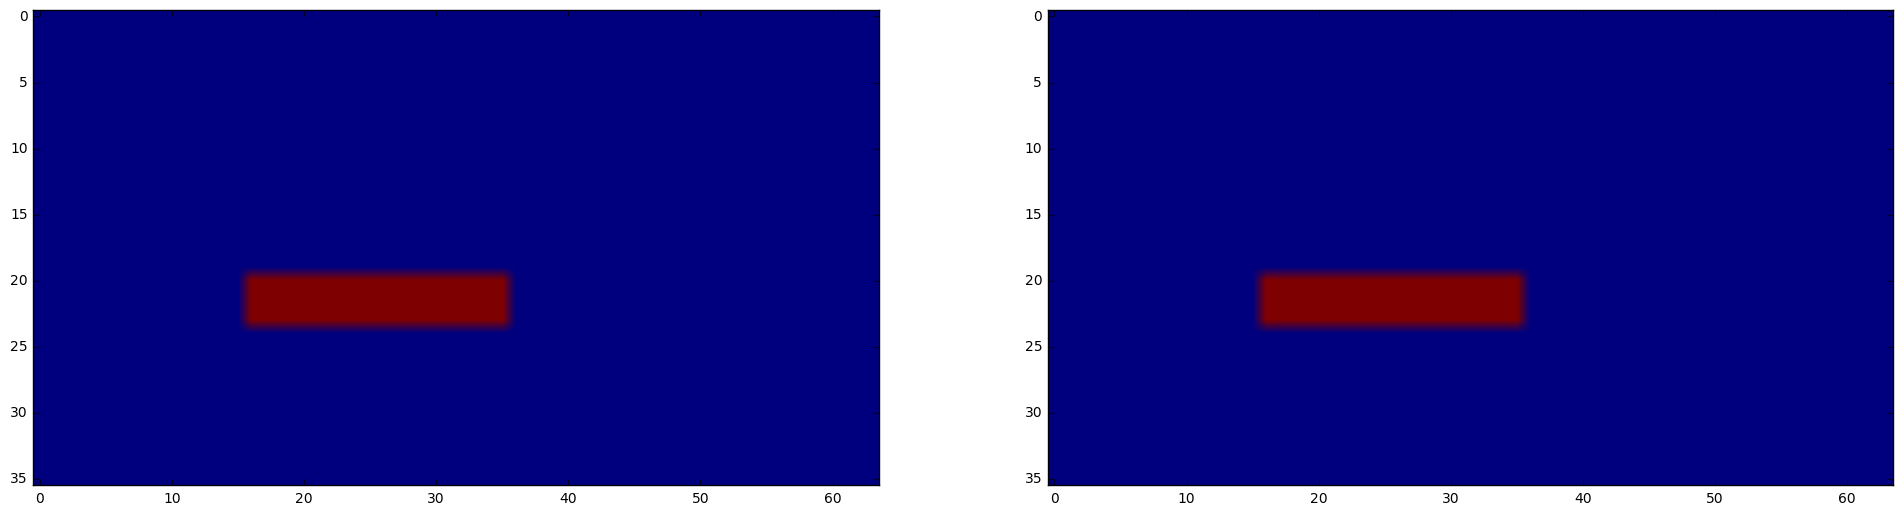

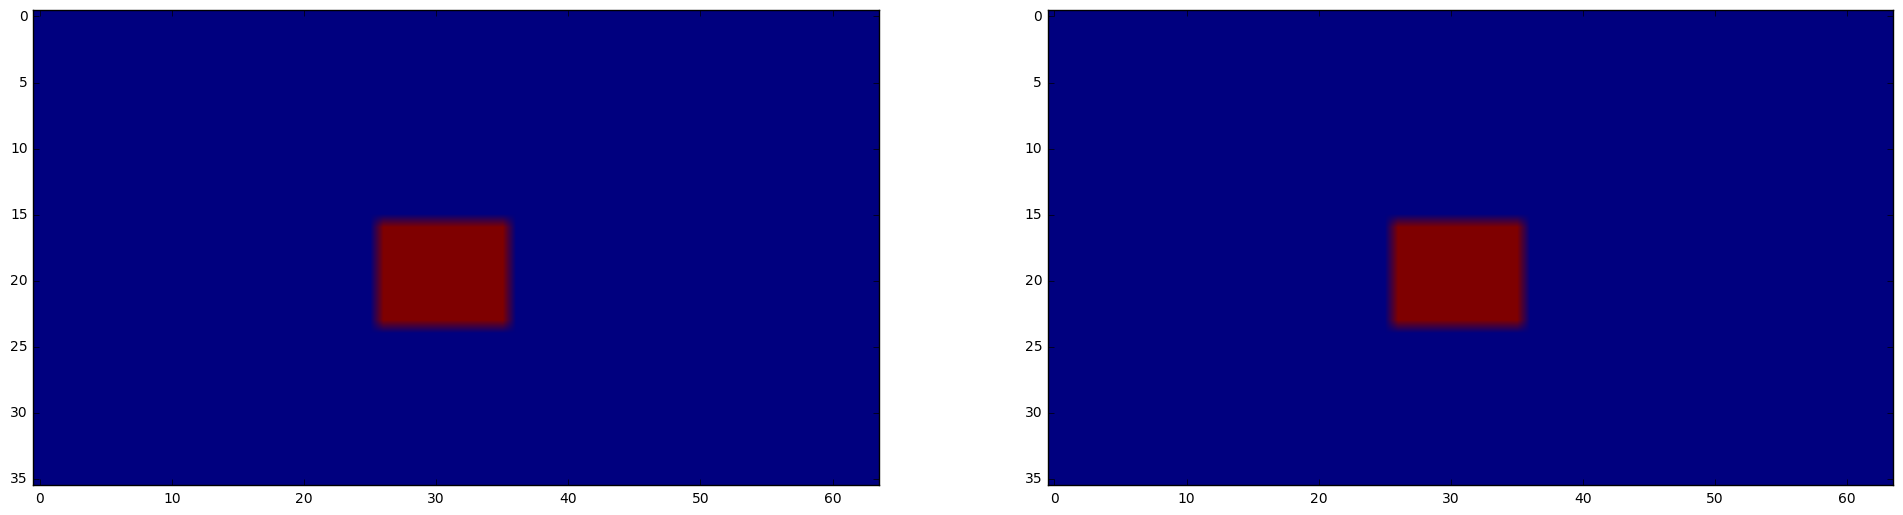

In [13]:
for i in range(4):
    print(paths[i])
    plt.imshow(load_img(paths[i]))
    plt.show()
    for j in range(5):
        plt.figure(figsize=(24,24))
        plt.subplot(1,2,1)
        plt.imshow(np.reshape(Y[j][i],mask_size[1]))
        plt.subplot(1,2,2)
        plt.imshow(np.reshape(W[j][i],mask_size[1]))        
        plt.show()

In [ ]:
train_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size)
test_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size)

In [ ]:
def img_mask_generator(batch_size, nb_filters, mask_size, folder, file_list):
    reshaped = mask_size[0]*mask_size[1]
    
    X = np.zeros((batch_size, nb_filters)+mask_size)
    Y = [np.zeros((batch_size, reshaped,1)) for _ in range(5)]
    W = [np.zeros((batch_size, reshaped))   for _ in range(5)]
    
    
    while True:

        selected_files = random.sample(file_list, batch_size)
        meta = [metadata[x] for x in selected_files]
        
        # We loop over the files
        for c, v in enumerate(meta):
            
            masks, m_weights = h_gen.get_5_masks_w(v, mask_size)
            
            m_weights = np.expand_dims(m_weights, axis=0)
            m_weights = np.reshape(m_weights,(reshaped,))
            
            # loop over the 5 masks
            for i, mask in enumerate(masks):
                
                mask0 = np.expand_dims(mask, axis=0)
                mask0 = np.reshape(mask0,(reshaped,))
                y = np.expand_dims(mask0, axis=1)

                X[c] = utils.load_array(folder + v["filename"])
                Y[i][c] = y
                W[i][c] = m_weights

        yield X, Y, W
            

## Third step, create the network.

##### First, let's create the network that will be shared:

In [14]:
nb_input_filters = 1000
print(mask_size)
print(nb_filters)
# We put this value so that we can reuse the weights of the final layer of the resnet.

[(18, 32), (36, 64)]
2048


In [35]:
def Conv2DReluBatchNorm(n_filter, w_filter, h_filter, inputs):
    return BatchNormalization()(Activation(activation='relu')(Convolution2D(n_filter, w_filter, h_filter, border_mode='same')(inputs)))
def model_custom_1(nb_input_filters):
    img_input = Input(shape=(nb_input_filters,) + (None,None)) 
    x = Convolution2D(512, 1, 1, activation='relu')(img_input)
    #x = BatchNormalization(axis=1)(x)
    x = Convolution2D(256, 1, 1, activation='relu')(x)
    #x = BatchNormalization(axis=1)(x)
    x = Convolution2D(128, 1, 1, activation='relu')(x)
    #x = BatchNormalization(axis=1)(x)
    last_filter = 64
    x = Convolution2D(last_filter, 1, 1, activation='relu')(x)
    return Model(input=img_input,output=x), last_filter

def model_custom_2(nb_input_filters):
    a,b = tuple([Input(shape=(nb_input_filters,) + m) for m in mask_size])

    c = Convolution2D(16, 1, 1, activation='relu')(a)
    #c = BatchNormalization(axis=1)(c)
    c = Convolution2D(16, 1, 1, activation='relu')(c)
    #c = BatchNormalization(axis=1)(c)
    c = UpSampling2D(size=(2, 2), dim_ordering='default')(c)
    
    d = Convolution2D(16, 1, 1, activation='relu')(b)
    #d = BatchNormalization(axis=1)(d)
    d = Convolution2D(16, 1, 1, activation='relu')(d)
    #d = BatchNormalization(axis=1)(d)
    e = Merge(mode='concat', concat_axis=1)([c,d])

    #e = BatchNormalization(axis=1)(e)
    e = Convolution2D(16, 1, 1, activation='relu')(e)
    #e = BatchNormalization(axis=0)(e)
    e = Convolution2D(16, 1, 1, activation='relu')(e)
    #e = BatchNormalization(axis=1)(e)
    e = Convolution2D(1, 1, 1, activation='linear')(e)
    #e = BatchNormalization(axis=1)(e)

    e = Reshape((1, mask_size[1][0]*mask_size[1][1]))(e)
    e = Permute((2, 1))(e)
    
    return Model(input=[a,b],output=e)

##### Here is the final network:

In [36]:
nb_input_filters = 1000
from keras.backend import shape as sh
print(nb_filters,mask_size)
img_inputs = [Input(shape=(nb_filters,) + m) for m in mask_size]
print(img_inputs)

first_con = Convolution2D(nb_input_filters, 1, 1, activation='relu')
x, y = [first_con(inp) for inp in img_inputs]

x = BatchNormalization(axis=1)(x)
y = BatchNormalization(axis=1)(y)

W = []
for _ in range(5):
    model_cus_1, last_filter = model_custom_1(nb_input_filters)
    w = model_cus_1(x)
    z = model_cus_1(y)
    W.append((w,z))
    
Z=[]
for a,b in W:
    model_cus_2 = model_custom_2(last_filter)
    k = model_cus_2([a,b])
    Z.append(k)
    
model = Model(input=img_inputs, output=Z)

2048 [(18, 32), (36, 64)]
[input_155, input_156]
Shape.0
Shape.0
Shape.0
Shape.0
Shape.0


In [41]:
model.layers[-2].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_168 (InputLayer)           (None, 64, 18, 32)    0                                            
____________________________________________________________________________________________________
convolution2d_541 (Convolution2D (None, 16, 18, 32)    1040        input_168[0][0]                  
____________________________________________________________________________________________________
input_169 (InputLayer)           (None, 64, 36, 64)    0                                            
____________________________________________________________________________________________________
convolution2d_542 (Convolution2D (None, 16, 18, 32)    272         convolution2d_541[0][0]          
___________________________________________________________________________________________

##### Let's insert the imageNet weights:

In [ ]:
# We need the last weights of the resnet50:
resnet = ResNet50()

In [ ]:
model.layers[2]

In [ ]:
resnet.layers[-1]

In [ ]:
heatmap.insert_weights(resnet.layers[-1], model.layers[2])

In [ ]:
model_file = "models/resnet_mask_training.h5"
mk('models/')

In [ ]:
# we can now save the model.
model.save(model_file)

## Fourth step, training.

In [ ]:
del resnet
gc.collect()

In [ ]:
model_file = "models/resnet_mask_training.h5"
model = load_model(model_file)

In [ ]:
#model.summary()

In [ ]:
model.layers[2].trainable=False

In [ ]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.0, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=adam, sample_weight_mode="temporal")

In [ ]:
train_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size)
test_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size)
history = model.fit_generator(train_gen, samples_per_epoch=2, nb_epoch=150, callbacks=[remote], 
                              verbose=0,validation_data=test_gen, nb_val_samples=2)
# 

In [ ]:
model.layers[2].trainable=True

In [ ]:
sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.0, nesterov=True)
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [ ]:
train_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size)
test_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size)
history = model.fit_generator(train_gen, samples_per_epoch=2, nb_epoch=25, callbacks=[remote], 
                              verbose=0,validation_data=test_gen, nb_val_samples=2)
# 

In [ ]:
file_trained = "models/fish_detection_trained_1.1.h5"

In [ ]:
model.save(file_trained)

In [ ]:
model = load_model(file_trained)

## Fifth step, display results.

In [ ]:
import sys
sys.path.insert(0, '../python_scripts')
import h_gen
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
import matplotlib.patches as patches
import numpy as np
import utils
import importlib
import threading
import meta
import heatmap
import itertools
import heatmap
import time
from numpy import unravel_index
import heatmaps_to_rect as htr
importlib.reload(htr)
importlib.reload(utils)
importlib.reload(meta)
importlib.reload(h_gen)

<h1> STATISCAL ANALYSIS OF MEAN_MAX RESULTS </h1>

In [ ]:
Final = []
c = tq(total=100*16)
N = 100
n = 0
for X, Y, W , paths,is_rects in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size, with_name=True, shuffle=False,debug2=True):
    Z = model.predict(X)   
    n +=1
    if n < N:
        for i in range(16):
            c.update()
            maxs = []
            for j in range(5):
                maxs.append(np.max(Z[j][i]))
            mean_max = np.array(maxs).mean()
            try:
                Final.append([mean_max,is_rects[i]])
            except:
                pass
    else:
        break
import pickle        
pickle.dump( Final, open( "Final.p", "wb" ) )

In [ ]:
Final = pickle.load( open( "Final.p", "rb" ) )

In [ ]:
w_f = []
wo_f = []
for i in range(len(Final)):
    if Final[i][1]:
        w_f.append(Final[i][0])
    else:
        wo_f.append(Final[i][0])
w_f = np.array(w_f) 
wo_f = np.array(wo_f) 
print('LENGTH OF TEST : '+str(len(Final)))
print('mean w_f : '+str(np.array(w_f).mean()))
print('mean wo_f : '+str(np.array(wo_f).mean()))
print('min w_f : '+str(np.array(w_f).min()))
print('min wo_f : '+str(np.array(wo_f).min()))
print('std w_f : '+str(np.array(w_f).std()))
print('std wo_f : '+str(np.array(wo_f).std()))
print('THRESHOLD : '+str(np.array(w_f).mean() - np.array(w_f).std()))

In [ ]:
w_f = np.array(w_f)
wo_f = np.array(wo_f)
hist, bin_edges = np.histogram(w_f, bins = 100)
plt.bar(bin_edges[:-1], hist)
#plt.bar(bin_edges[:-1], scipy.stats.norm.pdf(bin_edges[:-1], loc=t[1], scale=t[2]))
plt.xlim(0, 2*w_f.max())
plt.show()  

In [ ]:
hist, bin_edges = np.histogram(wo_f, bins = 'sqrt')
plt.bar(bin_edges[:-1], hist)
plt.xlim(0, 2*w_f.max())
plt.show()  

In [ ]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in tq(DISTRIBUTIONS):

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(w_f)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(w_f, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [ ]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions t,st.levyo check
#    DISTRIBUTIONS = [     ,st.mielke,st.nakagami,st.ncx2,st.ncf,   
#       st.gilbrat,st.lomax
#    ]        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        #st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
    DISTRIBUTIONS = [        
         st.lomax#st.gilbrat,
    ]
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in tq(DISTRIBUTIONS):

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (st.lomax.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(wo_f)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(w_f, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF
pdf1 = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [ ]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions t,st.levyo check
#    DISTRIBUTIONS = [     ,st.mielke,st.nakagami,st.ncx2,st.ncf,   
#       st.gilbrat,st.lomax
#    ]        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        #st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
    DISTRIBUTIONS = [        
         st.gilbrat#,st.lomax
    ]
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in tq(DISTRIBUTIONS):

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(wo_f)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(w_f, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF
pdf2 = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [ ]:
MAX_NOF = wo_f.max()
MIN_F = w_f.min()
plt.figure()
plt.plot(pdf2)
plt.plot(pdf)
plt.xlim(0, 2*w_f.max())
x=np.percentile(pdf,5)
y=np.percentile(pdf,95)
#y = np.percentile(pdf1,26)
#print('y :'+str(y))
print('x :'+str(x))
plt.axvline(x=x)
plt.axvline(x=y)
print('INTEGRAL PDF at x : '+str(pdf[(pdf<=x)].count()/len(pdf)))
print('INTEGRAL PDF at x : '+str(pdf2[(pdf2<=x)].count()/len(pdf2)))
plt.show()

In [ ]:
distance = []
for i in range(0,100):
    x=np.percentile(pdf,i)
    pdf1[(pdf1<x)].count()/len(pdf1)
    distance.append(pdf[(pdf<x)].count()/len(pdf)-pdf2[(pdf2<x)].count()/len(pdf2))
distance = np.array(distance)
plt.figure()
plt.plot(distance)
k_max = np.where(distance==distance.max())[0][0]
k_min = np.where(distance==distance.min())[0][0]
print(k_max,k_min)
TH_FISH_MM = x=np.percentile(pdf,k_max)
TH_NO_FISH_MM = x=np.percentile(pdf,k_min)
print(TH_FISH_MM,TH_NO_FISH_MM)
#print(distance.max(),distance[np.where(distance == distance.max())])

In [ ]:
# MEASURE ACCURANCY OF THRESHOLD
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
    for i in range(len(y_hat)): 
        if y_hat[i]==1 and y_actual!=y_hat[i]:
           FP += 1
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TN += 1
    for i in range(len(y_hat)): 
        if y_hat[i]==0 and y_actual!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

<h1> DISPLAY TEST PREDICTION </h1>

In [ ]:
# VALUES TO BE ALMOST SURE FOR EXCLUSION : RESULTAT .
TH_PARAMS = {'TH_NO_FISH_MM':TH_NO_FISH_MM}

In [ ]:
for X, Y, W , paths in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size, with_name=True, seed=6):
    break

In [ ]:
Z = model.predict(X)

In [ ]:
importlib.reload(htr)
importlib.reload(utils)
importlib.reload(meta)
importlib.reload(h_gen)

In [ ]:
for i in range(4,8):
    print(paths[i])
    plt.imshow(load_img(paths[i]))
    plt.show()
    maxs = []
    for j in range(5):
        plt.figure(figsize=(24,24))
        plt.subplot(1,2,1)
        plt.imshow(np.reshape(Y[j][i],mask_size[1]))
        plt.subplot(1,2,2)
        plt.imshow(np.reshape(Z[j][i],mask_size[1]))
        plt.show()
        print("max: ", np.max(Z[j][i]))
        print("min: ", np.min(Z[j][i]))
        maxs.append(maxs)
    mean_max = np.array(maxs).mean()
        
    masks = np.array([np.reshape(Z[j][i],mask_size[1]) for j in range(5)])
    print(masks.shape)
    #rectangles = htr.find_rectangles([masks],mean_max,TH_PARAMS, threshold=100, ranges=(2,20), clip=0.20, debug=True,
    #                    border_conf=[(11,3),(71,10)], batch_size=1, max_fish=10)

In [ ]:
for X, Y, W , paths,is_rects in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size, with_name=True, shuffle=False,debug2=True):
    break

In [ ]:
file = './models/yoloduswag.h5'
model = load_model(file)

In [ ]:
Z = model.predict(X)

In [ ]:
importlib.reload(htr)

In [ ]:
for i in range(4):
    print(paths[i])
    plt.imshow(load_img(paths[i]))
    plt.show()
    maxs = []
    for j in range(5):
        plt.figure(figsize=(24,24))
        plt.subplot(1,2,1)
        plt.imshow(np.reshape(Y[j][i],mask_size[1]))
        plt.subplot(1,2,2)
        plt.imshow(np.reshape(Z[j][i],mask_size[1]))
        plt.show()
        print("max: ", np.max(Z[j][i]))
        print("min: ", np.min(Z[j][i]))
        maxs.append(np.max(Z[j][i]))
    mean_max = np.array(maxs).mean()
    masks = np.array([np.reshape(Z[j][i],mask_size[1]) for j in range(5)])
    print(masks.shape)
    #rectangles = htr.find_rectangles([masks],mean_max, threshold=100, ranges=(5,20), clip=0.20, debug=True,
    #                    border_conf=[(11,3),(71,10)], batch_size=1, max_fish=10)

In [ ]:
def img_mask_generator(batch_size=32, image_size = (224,224),mask_size=(100,100), lambda_ratio=10):
    reshaped = mask_size[0]*mask_size[1]
    
    X = np.zeros((batch_size, 3)+image_size)
    #X = np.ones((batch_size, 1)+mask_size)
    #Y = np.zeros((batch_size, mask_size[0]*mask_size[1], 2))
    Y = np.zeros((batch_size, reshaped,1))
    W = np.zeros((batch_size, reshaped))
    while True:
        c=0
        for key, v in metadata.items():
            
            # First of all, if there is no rectangle and the image is not in NoF, 
            # then there is a problem.
            
            if v["class"] != "NoF" and "rectangles" not in v:
                continue
            mask0 = np.expand_dims(h_gen.get_mask(v, mask_size), axis=0)
            mask0 = np.reshape(mask0,(reshaped,))
            
            y = np.expand_dims(mask0, axis=1)

            X[c] = img_to_array(load_img(v["path"],target_size=image_size))
            Y[c] = y
            W[c] = mask0*(lambda_ratio-1) + np.ones(mask0.shape)
            c+=1
            
            if c == batch_size:
                c = 0 
                yield X, Y, W
            

In [ ]:
batch_size = 2
image_size = (720,1280)
lambda_ratio = 20

for X, Y, W in img_mask_generator(batch_size, image_size,(100,100), lambda_ratio):
    break

In [ ]:
batch_size = 2

lambda_ratio = 20

In [ ]:
model1 = ResNet50(include_top=False)
for layer in model1.layers:
    layer.trainable=False

In [ ]:
model1 = heatmap.to_heatmap(model1)

In [ ]:
for layer in model1.layers:
    layer.trainable=False

In [ ]:
model1.layers[-2]

In [ ]:
a,b,c = heatmap.get_dim(model1,-2, input_shape=(3,) + image_size)

In [ ]:
b,c

In [ ]:
a

In [ ]:
mask_size = (23, 40)

In [ ]:
mask_size = (b,c)

In [ ]:
img_a = Input(shape=(3,) + image_size)
model2 = Model(model1.input, model1.layers[-2].output)
x = model2(img_a)
x = AveragePooling2D(pool_size=(7, 7), strides=(1,1), border_mode="same")(x)
x = Convolution2D(1024, 1, 1, activation='relu')(x)
x = Convolution2D(512, 1, 1, activation='relu')(x)
x = Convolution2D(256, 1, 1, activation='relu')(x)
x = Convolution2D(128, 1, 1, activation='relu')(x)
x = Convolution2D(32, 1, 1, activation='relu')(x)
x = Convolution2D(16, 1, 1, activation='relu')(x)
x = Convolution2D(1, 1, 1, activation='linear')(x)
#x = LeakyReLU(alpha=0.3)(x)
x = Reshape((1, b*c))(x)
x = Permute((2, 1))(x)
model = Model(img_a,x)

In [ ]:
model2.summary()

In [ ]:
model.summary()

In [ ]:
sgd = SGD(lr=0.000001, decay=1e-6, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [ ]:
history = model.fit_generator(img_mask_generator(batch_size, image_size,mask_size, lambda_ratio), 
                    samples_per_epoch=8, nb_epoch=500, callbacks=[remote], verbose=0)

In [ ]:
for X, Y, W in img_mask_generator(batch_size, image_size,mask_size, lambda_ratio):
    Z = model.predict(X)
    break

In [ ]:
plt.imshow(array_to_img(X[0]))
plt.show()
plt.imshow(np.swapaxes(np.reshape(Y[0],(c,b)),0,1))
plt.show()
plt.imshow(np.swapaxes(np.reshape(Z[0],(c,b)),0,1) - np.min(Z[0]))
plt.show()
a = Z[0]
idx = Z[0][:,:] > 1
a[idx] = 1
idx = Z[0][:,:] < 0
a[idx] = 0 
plt.imshow(np.swapaxes(np.reshape(a,(c,b)),0,1))
plt.show()


In [ ]:
np.max(Z[0])

In [ ]:
np.min(Z[0])

In [ ]:
img_a = Input(shape=(3,) + image_size)
model2 = Model(model1.input, model1.layers[-2].output)
x = model2(img_a)
x = AveragePooling2D(pool_size=(7, 7), strides=(1,1), border_mode="same")(x)
model = Model(img_a,x)

In [ ]:
X = np.zeros((1, 3)+image_size)
for key, v in metadata.items():
    
    # First of all, if there is no rectangle and the image is not in NoF, 
    # then there is a problem.

    if v["class"] != "NoF" and "rectangles" not in v:
        continue

    #X[0] = img_to_array(load_img(v["path"],target_size=image_size))
    #y = model.predict(X)[0]
    y = utils.load("out_resnet/" + v["filename"])
    utils.save_array(y, "out_resnet/bco/" + v["filename"])

In [ ]:
def img_mask_generator(batch_size=32, image_size = (224,224),mask_size=(100,100), lambda_ratio=10, buffer_size=100):
    reshaped = mask_size[0]*mask_size[1]
    buffer = np.zeros((buffer_size, 2048) + mask_size)
    buffer_names = {}
    X = np.zeros((batch_size, 2048) + mask_size)
    Y = np.zeros((batch_size, 2048) + mask_size)
    #X = np.ones((batch_size, 1)+mask_size)
    #Y = np.zeros((batch_size, mask_size[0]*mask_size[1], 2))
    #Y = np.zeros((batch_size, reshaped,1))
    W = np.zeros((batch_size, reshaped))
    buffer_count = 0
    while True:
        c=0
        t = time.time()
        for key, v in metadata.items():
            
            # First of all, if there is no rectangle and the image is not in NoF, 
            # then there is a problem.
            
            if v["class"] != "NoF" and "rectangles" not in v:
                continue
            """mask0 = np.expand_dims(h_gen.get_mask(v, mask_size[::-1]), axis=0)
            mask0 = np.reshape(mask0,(reshaped,))
            #print(v["class"], v["filename"])
            y = np.expand_dims(mask0, axis=1)"""
            try:
                idx = buffer_names[v["filename"]]
                x = buffer[idx]
            except KeyError:
                x = utils.load_array("out_resnet/bco/" + v["filename"])
            
            if buffer_count < buffer_size:
                buffer[buffer_count] = x
                buffer_names[v["filename"]] = buffer_count
                buffer_count+=1
            
            X[c] = x
            Y[c] = x
            #W[c] = mask0*(lambda_ratio-1) + np.ones(mask0.shape)
            c+=1
            
            if c == batch_size:
                c = 0 
                yield X, Y
                #yield X, Y, W
        print(time.time() - t)

In [ ]:
img_a = Input(shape=(2048,) + mask_size)
x = Convolution2D(1024, 1, 1, activation='relu')(img_a)
x = Convolution2D(512, 1, 1, activation='relu')(x)
x = Convolution2D(1024, 1, 1, activation='relu')(x)
x = Convolution2D(2048, 1, 1, activation='linear')(x)
model = Model(img_a,x)

In [ ]:
sgd = SGD(lr=15, decay=0.001, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [ ]:
history = model.fit_generator(img_mask_generator(32, image_size,mask_size, lambda_ratio), 
                    samples_per_epoch=128, nb_epoch=5000, callbacks=[remote], verbose=0)

In [ ]:
def img_mask_generator(batch_size=32, image_size = (224,224),mask_size=(100,100), lambda_ratio=10, buffer_size=100):
    reshaped = mask_size[0]*mask_size[1]
    buffer = np.zeros((buffer_size, 2048) + mask_size)
    buffer_names = {}
    X = np.zeros((batch_size, 2048) + mask_size)
    #X = np.ones((batch_size, 1)+mask_size)
    #Y = np.zeros((batch_size, mask_size[0]*mask_size[1], 2))
    Y = np.zeros((batch_size, reshaped,1))
    W = np.zeros((batch_size, reshaped))
    buffer_count = 0
    while True:
        c=0
        t = time.time()
        for key, v in metadata.items():
            
            # First of all, if there is no rectangle and the image is not in NoF, 
            # then there is a problem.
            
            if v["class"] != "NoF" and "rectangles" not in v:
                continue
            """mask0 = np.expand_dims(h_gen.get_mask(v, mask_size[::-1]), axis=0)
            mask0 = np.reshape(mask0,(reshaped,))
            #print(v["class"], v["filename"])
            y = np.expand_dims(mask0, axis=1)"""
            try:
                idx = buffer_names[v["filename"]]
                x = buffer[idx]
            except KeyError:
                x = utils.load_array("out_resnet/bco/" + v["filename"])
            
            if buffer_count < buffer_size:
                buffer[buffer_count] = x
                buffer_names[v["filename"]] = buffer_count
                #buffer_count+=1
            
            X[c] = x
            #Y[c] = y
            #W[c] = mask0*(lambda_ratio-1) + np.ones(mask0.shape)
            c+=1
            
            if c == batch_size:
                c = 0 
                yield X, Y, W
        print(time.time() - t)

In [ ]:
for X, Y, W in img_mask_generator(8, image_size,mask_size, lambda_ratio):
    Z = model.predict(X)
    break

In [ ]:
mask_size = (23,40)

In [ ]:
for i in range(0,8):
    plt.imshow(np.reshape(Y[i],(b,c)))
    plt.show()
    print("max: " + str(np.max(Z[i])))
    print("min: " + str(np.min(Z[i])))
    print("loss= " + str(np.sum(np.square(Y[i]-Z[i])*Y[i]*(lambda_ratio-1) + np.ones(Y[i].shape))/(23*40)))
    plt.imshow(np.reshape(Z[i],(b,c)))
    plt.show()

In [ ]:
np.min(Z)

In [ ]:
mask_size = (23,40)

In [ ]:
b,c = 23,40

In [ ]:
img_a = Input(shape=(2048,) + mask_size)
x = Convolution2D(1024, 1, 1, activation='relu')(img_a)
x = Convolution2D(512, 1, 1, activation='relu')(x)
x = Convolution2D(256, 1, 1, activation='relu')(x)
x = Convolution2D(128, 1, 1, activation='relu')(x)
x = Convolution2D(32, 1, 1, activation='relu')(x)
x = Convolution2D(16, 1, 1, activation='relu')(x)
x = Convolution2D(1, 1, 1, activation='linear')(x)
#x = LeakyReLU(alpha=0.3)(x)
x = Reshape((1, b*c))(x)
x = Permute((2, 1))(x)
model = Model(img_a,x)

In [ ]:
sgd = SGD(lr=0.001, decay=0.001, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [ ]:
history = model.fit_generator(img_mask_generator(64, image_size,mask_size, lambda_ratio), 
                    samples_per_epoch=128, nb_epoch=5000, callbacks=[remote], verbose=0)

In [ ]:
np.sum(Z[0])

In [ ]:
np.all(np.equal(Y[0], Z[0]))

In [ ]:
np.sum(Z[0])

In [ ]:
img_input = Input(shape=(1,100,100))
x = Convolution2D(1, 1, 1, border_mode="same")(img_input)
#x = Permute((1,2))(x)
#x = Permute((1,3))(x)
x = Reshape((1, 100*100))(x)
x = Permute((2, 1))(x)
#x = heatmap.Softmax4D(axis=1,name="softmax")(x)
model = Model(img_input,x)

In [ ]:
model.layers[1].trainable = True

In [ ]:
a = model.layers[1].get_weights()

In [ ]:
a[1][0] = 0

In [ ]:
a[0][0,0,0,0] = 1

In [ ]:
model.layers[1].set_weights(a)

In [ ]:
model.layers[1].get_weights()

In [ ]:
model.layers[1].get_config()

In [ ]:
model.summary()

In [ ]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [ ]:
model.fit_generator(img_mask_generator(batch_size=3000), samples_per_epoch=32, nb_epoch=20, callbacks=[remote], verbose=0)

In [ ]:
Z = model.predict(X)

In [ ]:
np.max(Z[0])